# Raster Vectorizer using Matplotlib Contour Plot and Shapely

In [232]:
import numpy as np
import matplotlib.pyplot as plt

In [233]:
from shapely.geometry import Polygon, MultiPolygon, LineString, MultiLineString, Point
from shapely.ops import split

In [234]:
import ezdxf

## Test Image Generation

In [84]:
%matplotlib inline

plt.style.use('seaborn-white')


In [85]:
def f(x, y):
    value = np.sin(x) ** 10 + np.cos(10 + y * x) * np.cos(x)
    inCircle = (x-2.5)**2 + (y-2.5)**2 < 5**2
    return inCircle*value

In [86]:
cx = 2.5
mx = 5.5
cy = 2.5
my = 5.5

In [87]:
x = np.linspace(cx - mx, cx + my, 300)
y = np.linspace(cy - my, cy + my, 300)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

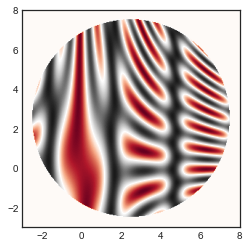

In [88]:
plt.imshow(Z, extent=[cx - mx, cx + my, cy - my, cy + my], origin='lower',
           cmap='RdGy')

## Conversion of image to Matplotlib Countours using `counterf`.

Here we find the contours using matplotlib's contourf function.

The levels argument can be used to define one or more collections of shapes (called `paths`).  For instance `[0.5, 0.75, 1.00]` would define two regions, i.e. `[0.5, 0.75]` and `[0.75, 1.00]`.

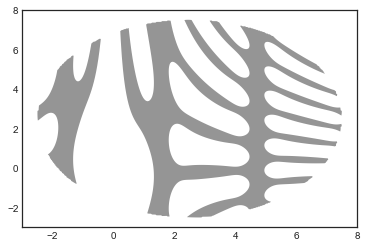

In [124]:
regions = plt.contourf(X, Y, Z, levels=[0.5, 1000], antialiased=True)

## Conversion of Matplotlib `counterf` data into Shapely polygons.

In [125]:
pathCollections = regions.collections

When we define only two levels, there can be only one path collection.  We select it.

In [126]:
pathCollection = pathCollections[0]

Note that the paths are encoded.  They begin with a list of x-y points and then 
follow with an array of integers specifying how to interpret those points.

The `pathCollection` consists of one or more paths.  A `path` is a collection of polygons in which the first is the outer boundary and the rest are holes.  These are defined as one as a sequence of vertices followed by a sequence of action codes.  These are similar to what one find in an old style plotter.

In [127]:
paths = pathCollection.get_paths()

```
    # Path codes
    STOP = code_type(0)         # 1 vertex
    MOVETO = code_type(1)       # 1 vertex
    LINETO = code_type(2)       # 1 vertex
    CURVE3 = code_type(3)       # 2 vertices
    CURVE4 = code_type(4)       # 3 vertices
    CLOSEPOLY = code_type(79)   # 1 vertex

    #: A dictionary mapping Path codes to the number of vertices that the
    #: code expects.
    NUM_VERTICES_FOR_CODE = {STOP: 1,
                             MOVETO: 1,
                             LINETO: 1,
                             CURVE3: 2,
                             CURVE4: 3,
                             CLOSEPOLY: 1}
```

In [128]:
def convertPathToPolygons(path):
    """ Converts a matplotlib `path` into a list of polygons.  The first is assumed
    to be outermost while the subsequent ones are cut holes.

    The function maintains a running list of polygons.  Each vertex, code pair
    is iterated through.  A new polygon is begun on a "MOVETO" command, appended
    to on a "LINETO" command, and closed with a "CLOSEPOLY" command.
    """
    polys = []
    for pt, code in path.iter_segments():
        if code == 1:  # MOVETO
            curPoly = []
            curPoly.append(pt)
        if code == 2:  # LINETO
            curPoly.append(pt)
        if code in [3, 4]:
            print("warning: does not currently support CURVE3 or CURVE4")
        if code == 79:  # CLOSEPOLY
            curPoly.append(pt)
            polys.append(np.array(curPoly))
    return polys

Use the function above to convert the coded matplotlib paths into lists of polygons.  The final format of this will be of the form:
`pathVertObjects = [[outer1, hole1a, hole1b, ...], [outer2, hole2a, hole2b, ...], ...]`
where `outer` and `hole` are explicitly closed polygons.

In [129]:
polygons = [convertPathToPolygons(path) for path in paths]

Spot check that the polygons are explicitly closed by examining the `outer1` polygon above.

In [130]:
poly = polygons[0][0]
np.alltrue(poly[0] == poly[-1])

True

In [131]:
poly

array([[ 2.44481605, -2.48861651],
       [ 2.48160535, -2.49187344],
       [ 2.51839465, -2.49447259],
       ...,
       [ 2.44213107, -2.44816054],
       [ 2.4113715 , -2.48494983],
       [ 2.44481605, -2.48861651]])

In [132]:
def convertPolygonsToShapely(polys):
    """ Converts lists of lists of polygons into a shapely Multipolygon object.

    It is assumed that the first polygon in each list is the outermost one and
    subsequent ones are holes.
    """
    shPolys = []
    for pathVertObject in polys:
        poly = Polygon(shell=pathVertObject[0], holes=pathVertObject[1:])
        shPolys.append(poly)
    shape = MultiPolygon(shPolys)
    return shape

In [133]:
shape = convertPolygonsToShapely(polygons)

## Fun Shapely Operations

From here we can do all of the cool Shapely operations.  For instance, we can
* simplify an object
* buffer it inwards or outwards
* a whole suite of boolean operations

In [134]:
shapeSimp = shape.simplify(0.05, preserve_topology=True)

In [135]:
len(str(shape)), len(str(shapeSimp))

(163213, 7251)

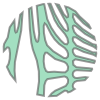

In [136]:
shapeSimp

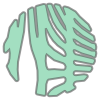

In [137]:
shapeSimp.buffer(0.2)

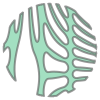

In [138]:
shape

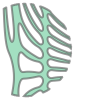

In [139]:
shape.geoms[0]

In [140]:
shape.geoms[1].area

5.717705269178009

In [141]:
pt1 = shape.geoms[1].centroid

In [142]:
pt1.x, pt1.y

(-1.4453368885397824, 3.0221018017041335)

## Flattening Shapely Nested Polygons into Closed Simple Polygons 

There are many ways that one can specify topology.  The shapely polygons above are specified as a list of a combination of outer shapes followed by inner holes. `[[outer1, hole1a, hole1b, ...], [outer2, hole2a, hole2b, ...], ...]`.  Note that `outer2` and its holes could all be contained within `hole1a`.

However, many pieces of software prefer that the structure has no nested topology at all.  How, then, does one then handle a hole?  One can imagine using a knife to make single slice through a donut, effectively connecting the hole to the outside on two edges, but not changing the specified area at all.  If one were to trace each "half", they would find that all contours are "outside" and there would be two coincident edges where the knife cut.  See Closed Simple Polygon for details.

The strategy for doing this will be as follows.  Go through each polygon.  If it has a hole, find the centroid of that hole.  Extend a cut line through this centroid of the hole to the left and right and split the polygon into two or more polygons using this cut line.  These new polygons will share boundaries, but will specify the same area as the original "holey" one.

In [158]:
def polyHasHoles(shPoly):
    nHoles = len(shPoly.interiors)
    return (nHoles > 0)

In [163]:
shPoly = shape.geoms[0]

In [187]:
polyHasHoles(shPoly)

True

In [188]:
def getPolygonFirstHoleCenter(shPoly):
    (xC, yC) = np.array(shPoly.interiors[0].centroid.xy).reshape(-1)
    return (xC, yC)

In [235]:
getPolygonFirstHoleCenter(shPoly)

(2.967221062266478, 0.9568700542701456)

In [236]:
def splitPolyOnFirstHole(shPoly):
    (xC, yC) = getPolygonFirstHoleCenter(shPoly)
    (minx, miny, maxx, maxy) = shPoly.bounds
    cutLine = LineString([[minx, yC], [maxx, yC]])
    geoCollection = split(shPoly, cutLine)
    return geoCollection

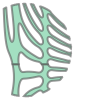

In [237]:
splitPolyOnFirstHole(shPoly)

In [238]:
def fixPolyInList(polyList):
    """Operates on list of polygons.  Goes through the polygons.  For the first 
    polygon that has a hole, that hole is excised and the resulting polygons are 
    appended to the end of the list.  Returns True.  If no holey polygons are
    found, returns False.

    Args:
        polyList ([type]): [description]

    Returns:
        [type]: [description]
    """
    for poly in polyList:
        if polyHasHoles(poly):
            badPoly = poly
            newPolys = splitPolyOnFirstHole(badPoly)
            polyList.remove(poly)
            polyList.extend([*(newPolys.geoms)])
            return True
    return False

In [216]:
polyList = [*(shape.geoms)]
polyList

In [217]:
fixPolyInList(polyList)

True

In [218]:
polyList

In [219]:
def fixHolelyMultiPolygon(mPoly):
    polyList = [*(mPoly.geoms)]
    while fixPolyInList(polyList): continue
    return MultiPolygon(polyList)

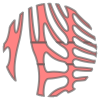

In [220]:
flatMPoly = fixHolelyMultiPolygon(shape)
flatMPoly

## Shapely Polygons to Vertex List

In [221]:
def convertShapelyToPolygons(shape):
    """ Converts a shapely Multipolygon into a list of list of vertices.

    This format should be suitable for rendering to dxf.
    """
    polyList = []
    for shP in shape.geoms:
        vList = np.array(list(zip(*shP.exterior.coords.xy)))
        polyList.append(vList)
        for intr in shP.interiors:
            vList = np.array(list(zip(*intr.coords.xy)))
            polyList.append(vList)
    return polyList

In [222]:
vListsFlat = convertShapelyToPolygons(flatMPoly)

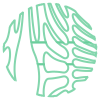

In [223]:
MultiLineString(vListsFlat)

## Writing DXFs

In [225]:
def saveDXF(fName, vLists, layer="content_layer"):
    doc = ezdxf.new('R12', setup=True)
    msp = doc.modelspace()
    for (i, vList) in enumerate(vLists):
        if layer == 'enum':
            msp.add_polyline2d(points=vList, dxfattribs={'layer': "layer"+str(i)})
        else:
            msp.add_polyline2d(points=vList, dxfattribs={'layer': layer})
    doc.saveas(fName)

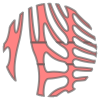

In [226]:
flatMPoly

In [227]:
vListsFlat = convertShapelyToPolygons(flatMPoly)

In [228]:
# saveDXF("flat.dxf", vListsFlat, 'enum')

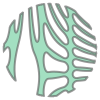

In [229]:
shape

In [230]:
vListsHoley = convertShapelyToPolygons(shape)

In [231]:
# saveDXF("holey.dxf", vListsHoley)

# Direct Image to DXF Transfer